In [151]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
np.random.seed(1001)

In this notebook, I want to showcase the use of eigenvalues and eigenvectors for non-linear optimization problems. In this particular example, we will use them to find an optimal rotation and translation in two dimensions.
 
A common task in robotics is to find spatial transformations $R_i,p_i$ in a way, such that some points $x_{k}$ align to a plane as close as possible. Classically, this would be done by estimating the planes parameters, given as normals $n_j$ and distances $d_j$ from the origin, along with the transformation parameters. Then for each point, one would compute the point to plane residual $n_j \cdot (R_i x_i + p_k) - d_j$. By minimizing those using least squares optimization, one can find the optimal parameters. Given $N_{Pose}$ poses and $N_{Plane}$ planes, the optimization objective would therefore look like the following:

$$
\begin{align*}
L(R_1, p_1, ..., R_{N_{Pose}}, p_{N_{Pose}}, n_1, d_1, ..., n_{N_{Plane}}, d_{N_{Plane}}) = \frac{1}{2}\sum_{i=1}^{N_{Pose}}\sum_{j=1}^{N_{Plane}}\sum_{k=1}^{N_{i, j}}(n_j \cdot (R_i x_k + p_i) - d_j)^2
\end{align*}
$$

Here, $N_{i, j}$ is the amount of points on plane $j$ coming from pose $i$. However, the more planes one has to fit the points on, the more parameters one has to optimize over. A plane can be described as a normal vector and a distance from the coordinate systems origin. Consequently, for each plane, one has to estimate 4 additional parameters. This can go out of hands pretty quickly for multiple planes.

Now, by using eigenvalues and eigenvectors, one can get rid of this issue. Without using any additional parameters for the planes, we are still able to precisely find the optimal solution to the stated problem. The actual loss function will be defined in two variations further down in this notebook. Without the additional parameters and taking only the transformation parameters as arguments, it will be simplified to the below:

$$
\begin{align*}
L(R_1, p_1, ..., R_{N_{Pose}}, p_{N_{Pose}})
\end{align*}
$$

What is here described with a plane and points in 3D, will for simplicity be demonstrated in this notebook with a line and points in 2D. However, as long as one wants to flatten data points to a hyperplane, the optimization through eigenvalues and eigenvectors offers a very elegant method to do so in any dimension.

For the start, let's define a function that outputs for an input vector *v* of shape $(3)$ a rotation and translation with shapes $(2, 2)$ and $(2, 1)$ respectively. The first two values of *v* thereby correspond to the x and y translation values, the last entry of *v* to the rotation angle in radians. If *derivative* is set to *True*, the jacobians of the rotation and translation with respect to *v* will be returned as well (where the first axis corresponds to *v*, so the outputs are of shape $(3, 2, 2)$ and $(3, 2, 1)$ respectively).

In [152]:
def transformation(v, derivative=False):
    x, y, a = v  # x, y translation; rotation angle a
    
    rot = np.array([[np.cos(a), -np.sin(a)],
                  [np.sin(a),  np.cos(a)]])
    trans = np.array([[x],
                  [y]])
    
    if derivative:
        d_rot = np.array([[[0, 0],
                         [0, 0]],
                        [[0, 0],
                         [0, 0]],
                        [[-np.sin(a), -np.cos(a)],
                         [ np.cos(a), -np.sin(a)]]])
        d_trans = np.array([[[1],
                         [0]],
                        [[0],
                         [1]],
                        [[0],
                         [0]]])
        
        return rot, trans, d_rot, d_trans
    
    else:
        return rot, trans

Now lets create some sample data. In this particular case, we want to create some points along lines.

In [153]:
n_lines = 3
n_points_per_line = 25

# create some almost linear points along the x-axis
points = np.random.randn(1, 1, n_points_per_line, 2, 1) * np.array([3e-1, 1e-2]).reshape(2, 1)

# create some variations of this line by rotating and translating it
for i in range(n_lines - 1):
    v = np.random.randn(3)
    rot, trans = transformation(v)
    
    points = np.append(points, rot @ points[[0], ...] + trans, axis=0)

The data's shape is of the form $(N_{lines}, 1, N_{points \text{ } per \text{ } line}, 2, 1)$. We therefore have $N_{lines}$ by $N_{points \text{ } per \text{ } line}$ points with two x and y coordinates each (seen as $(2, 1)$ vectors). The reason for the 1 at the second axis will become obvious soon.

For now, let's have a look at the data.

Data shape: (3, 1, 25, 2, 1)


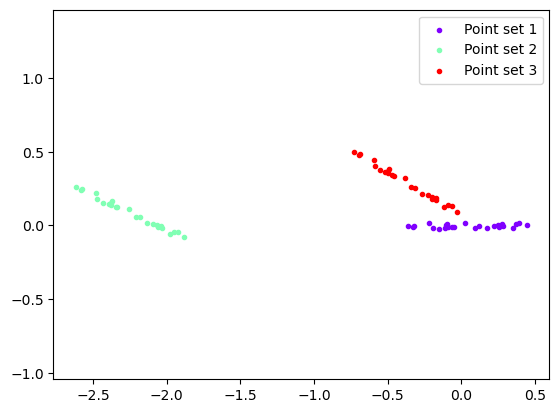

In [154]:
print(f"Data shape: {points.shape}")

colors = plt.cm.rainbow(np.linspace(0, 1, n_lines))
for i in range(n_lines):
    plt.scatter(points[i, :, :, 0, 0], points[i,:, :, 1, 0], 
                color=colors[i, :], marker='.', label=f"Point set {i+1}")
    
plt.axis('equal')
plt.legend()
plt.show()

We now assume this data is transformed by a rotation and translation, specified by *v_target* below.


In [155]:
v_target = np.array([0.5, 1, 2]) # x-translation, y-translation, rotation angle

rot, trans = transformation(v_target)
points = np.concatenate([points, rot @ points + trans], axis=1)

# Lets also add some noise to those transformed points
noise_level = 1e-2
points[:, 1, :, :, :] += np.random.randn(n_lines, n_points_per_line, 2, 1) * noise_level

We now see the use of the second axis, all our points are neatly vectorized. The untransformed and transformed points are specified at exactly this axis.

Let us take a second look at the data, the transformed points are shown by the x-marker. We can see how the two line sets, marked by dots and crosses, differ by exactly one rotation and translation.

New data shape: (3, 2, 25, 2, 1)


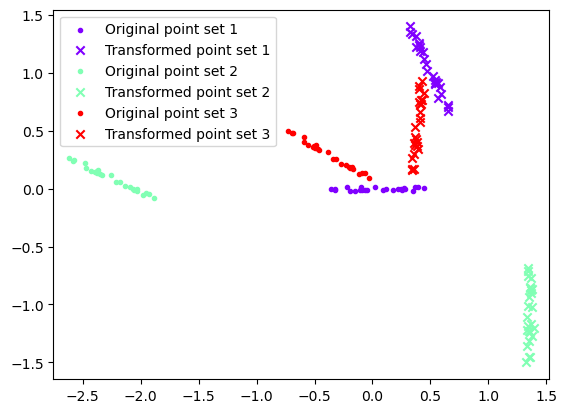

In [156]:
print(f"New data shape: {points.shape}")

colors = plt.cm.rainbow(np.linspace(0, 1, n_lines))
for i in range(n_lines):
    for j in range(2):
        plt.scatter(points[i, j, :, 0, 0], points[i, j, :, 1, 0], 
                    color=colors[i, :], marker='.' if j == 0 else 'x',
                    label=("Original" if j == 0 else "Transformed") + f" point set {i+1}")
    
plt.axis('equal')
plt.legend()
plt.show()

We further define a function computing for each pair of points (the original and transformed ones) their smallest eigenvalue and corresponding eigenvector. This computation will however only happen after we add an transformation, specified by the *v* parameter, to the previously untransformed points. Consequently, if we were to specify *v* to exactly match the above *v_target*, we would get the point sets to be aligned. The reasoning behind this logic will hopefully become become clear later on.

There exist multiple ways to compute eigenvalues and eigenvectors for a set of points. In our example we will focus on their computation using a Principal Component Analysis. Looking at the covariance matrix of the underlying points, we can then compute the corresponding eigenvalues and eigenvectors. For further detail about this computation, as well as the computation of the jacobians respective the parameter array *v*, we will refer to The Matrix Cookbook (https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf). 

For this example however, the exact details aren't that important. This notebook is rather aimed at giving an initial idea about the power of using eigenvalues and eigenvectors for optimization problems. A more detailed explanation which will hopefully deepen the understanding of the covariance matrix, eigenvalues, and eigenvectors will follow in the next cells.

In [157]:
def eigen(v, derivative=False):
    '''
    This function computes for each of the given point sets the corresponding eigenvalues and
    eigenvectors. Each of the sets consists of two subsets, namely the untransformed and transformed
    points. Given the transformation values in the v argument array, the untransformed points 
    will get transformed. Only after this transformation, the eigenvalues and eigenvectors then
    get computed.

    Since we want to do all those computations using vectorization, an identity translation and
    rotation is getting appended to the transformations computed from v. Using this technique, we can
    simultaneously transform both point subsets. However the second, already transformed set (by v_target),
    will in fact stay unaltered due to the identity transformations.
    '''
    if derivative:
        rot, trans, d_rot, d_trans = transformation(v, derivative=True)

        rot = np.stack([rot, np.eye(2)]).reshape(1, 2, 1, 2, 2)
        trans = np.stack([trans, np.zeros((2, 1))]).reshape(1, 2, 1, 2, 1)
        d_rot = np.concatenate([d_rot.reshape(3, 1, 1, 1, 2, 2), np.zeros((3, 1, 1, 1, 2, 2))], axis=2)
        d_trans = np.concatenate([d_trans.reshape(3, 1, 1, 1, 2, 1), np.zeros((3, 1, 1, 1, 2, 1))], axis=2)

        points_ = (rot @ points + trans).reshape(n_lines, -1, 2, 1)
        d_points_ = (d_rot @ points + d_trans).reshape(3, n_lines, -1, 2, 1)
        
        mean = np.mean(points_, axis=-3)
        d_mean = np.mean(d_points_, axis=-3)
        cov = np.mean(points_ @ np.swapaxes(points_, -1, -2), axis=-3) - \
            mean @ np.swapaxes(mean, -1, -2)
        d_cov = np.mean(d_points_ @ np.swapaxes(points_, -1, -2), axis=-3) + \
              np.mean(points_ @ np.swapaxes(d_points_, -1, -2), axis=-3) - \
              d_mean @ np.swapaxes(mean, -1, -2) - \
              mean @ np.swapaxes(d_mean, -1, -2)

        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        eigenvalues, eigenvectors = eigenvalues[:, [0], None], eigenvectors[:, :, [0]]

        d_eigenvalues = (np.swapaxes(eigenvectors, -1, -2) @ d_cov @ eigenvectors)
        d_eigenvectors = np.linalg.pinv(eigenvalues * np.eye(2) - cov) @ d_cov @ eigenvectors
        
        return eigenvalues, eigenvectors, d_eigenvalues, d_eigenvectors
    
    else:
        rot, trans = transformation(v, derivative=False)
        rot = np.stack([rot, np.eye(2)]).reshape(1, 2, 1, 2, 2)
        trans = np.stack([trans, np.zeros((2, 1))]).reshape(1, 2, 1, 2, 1)
        
        points_ = (rot @ points + trans).reshape(n_lines, -1, 2, 1)
        
        mean = np.mean(points_, axis=-3)
        cov = np.mean(points_ @ np.swapaxes(points_, -1, -2), axis=-3) - \
            mean @ np.swapaxes(mean, -1, -2)

        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        eigenvalues, eigenvectors = eigenvalues[:, [0], None], eigenvectors[:, :, [0]]

        return eigenvalues, eigenvectors

The ultimate aim of this notebook is to estimate the previously specified transformation parameters (the *v_target* array specified above) solely by looking at the underlying point data. That is, we want to answer the question about how can we move the dotted points in the image above, such that they align well with the crossed ones.

The optimal solution therefore should look like this. The two point sets overlap each other well.

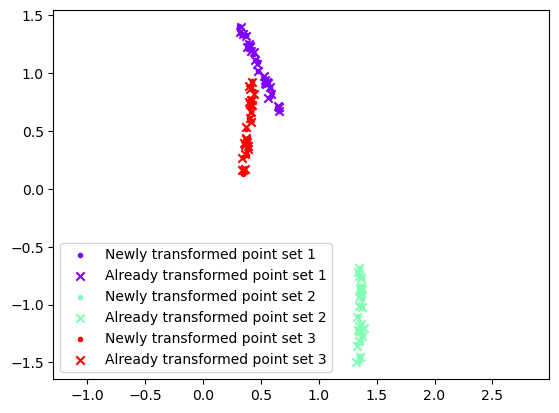

In [158]:
rot, trans = transformation(v_target)
points_ = points.copy()
points_[:, 0, :, :, :] = rot @ points_[:, 0, :, :, :] + trans

colors = plt.cm.rainbow(np.linspace(0, 1, n_lines))
for i in range(n_lines):
    for j in range(2):
        plt.scatter(points_[i, j, :, 0, 0], points_[i, j, :, 1, 0], 
                    color=colors[i, :], marker='.' if j == 0 else 'x',
                    label=("Newly" if j == 0 else "Already") + f" transformed point set {i+1}")
    
plt.axis('equal')
plt.legend()
plt.show()

In particular we want to achieve our task, finding *v_target*, by looking at eigenvalues and eigenvectors. What exactly do we mean by this? Let's consider an example and let look at another set of 2D data points first. We create those example points by sampling them from a gaussian distribution. To do so, we define the covariance and the mean of the distribution and then sample from it.

In [159]:
cov = np.array([[2.0, 0.4], [0.4, 0.2]])
mean = np.array([1, 2])

data = np.random.multivariate_normal(mean, cov, size=(100))

Let us have a look at the sampled points.


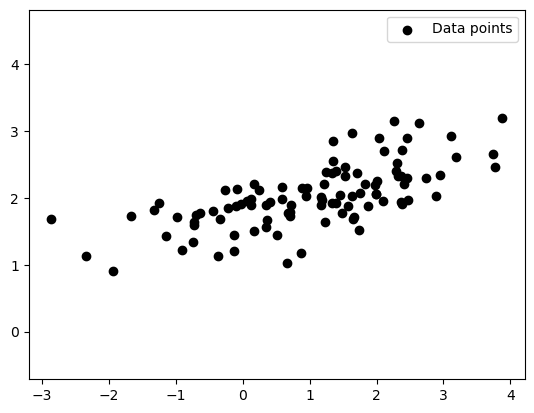

In [160]:
plt.scatter(data[:, 0], data[:, 1], c='k', label="Data points")
plt.axis('equal')
plt.legend()
plt.show()

We can see a linear shape within these data points. This shape can also be observed through the covariance matrix underlying them. If we compute the eigenvalues of eigenvectors and plot them on the data, we can observe how their direction and spread dictates its form.

That is, the eigenvectors give us the directions along which the data is spread out, while the magnitude of that spread is given by the corresponding eigenvalue. Now if we want to observe how linear some data points are, we can look at the eigenvalues. The smaller the smallest of the two eigenvalues is (while the other one is big), the more linear our points are. In our example the two eigenvalues are:

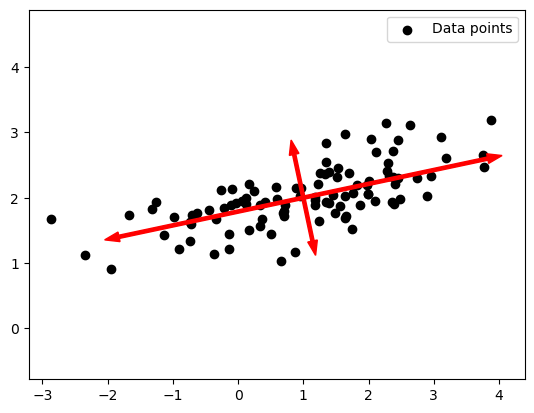

The eigenvalues: [0.11511422 2.08488578]


In [161]:
eigenvalues, eigenvectors = np.linalg.eigh(cov)

plt.scatter(data[:, 0], data[:, 1], c='k', label="Data points")
plt.arrow(mean[0], mean[1], 
          eigenvectors[0, 0] * 2 * np.sqrt(eigenvalues[0]), 
          eigenvectors[1, 0] * 2 * np.sqrt(eigenvalues[0]),
         color='r', width=0.05)
plt.arrow(mean[0], mean[1], 
          -eigenvectors[0, 0] * 2 * np.sqrt(eigenvalues[0]), 
          -eigenvectors[1, 0] * 2 * np.sqrt(eigenvalues[0]),
         color='r', width=0.05)
plt.arrow(mean[0], mean[1], 
          eigenvectors[0, 1] * 2 * np.sqrt(eigenvalues[1]), 
          eigenvectors[1, 1] * 2 * np.sqrt(eigenvalues[1]),
         color='r', width=0.05)
plt.arrow(mean[0], mean[1], 
          -eigenvectors[0, 1] * 2 * np.sqrt(eigenvalues[1]), 
          -eigenvectors[1, 1] * 2 * np.sqrt(eigenvalues[1]),
         color='r', width=0.05)
plt.axis('equal')
plt.legend()
plt.show()

print(f"The eigenvalues: {eigenvalues}")

In praxis, we will often not know the underlying covariance matrix describing some data points shape. We are typically only given the data points themselves. However, from those we can directly compute the covariance matrix ourselves. This is exactly what we defined our eigen function for. It computes for he linear points (untransformed and transformed) their covariance matrix and consequently the corresponding eigenvalues and eigenvectors (if specified, together with the jacobians respective the transformation parameters *v*).

With this theory in mind, lets look at the eigenvalues of our previous sample points above. If the two point sets are well aligned, that is, we know the optimal transformation *v*, all of our lines have a very small smallest eigenvalue. This makes sense since they are almost linear, as can be seen in the image above.

In [162]:
eigenvalues, eigenvectors = eigen(v_target)
print(f"Eigenvalues: {eigenvalues.reshape(-1)}")

Eigenvalues: [0.00015357 0.00018076 0.00015909]


If instead we take the unaligned points, that is, we compute the the eigenvalues of our point tuples while they are far apart, we can see how the respective eigenvalues are bigger. This makes sense, as in this case our point tuples aren't actually linear at all, but (close to) randomly scattered points in space.

In [163]:
eigenvalues, eigenvectors = eigen(np.array([0, 0, 0]))
print(f"Eigenvalues: {eigenvalues.reshape(-1)}")

Eigenvalues: [0.0398517  0.02715278 0.03966742]


So if we want to find the optimal transformation values aligning the point tuples, we can look at their eigenvalues. If we manage to gradually decrease them, we should be able to find the desired values. This sounds like an optimization problem! If we define the function computing the smallest eigenvalue for each of the planes point sets, given the spatial transformation $R_i,p_i$, as $E_j(R_1, p_1, ...,R_{N_{Pose}},p_{N_{Pose}})$, the optimization objective is now reduced to

$$
\begin{align*}
L(R_1, p_1, ..., R_{N_{Pose}}, p_{N_{Pose}}) = \sum_{j=1}^{N_{Plane}}E_j(R_1, p_1, ...,R_{N_{Pose}},p_{N_{Pose}})
\end{align*}
$$

Note how in this formula the line's parameters no longer appear. This is quite a big reduction of the complexity in the formulation of our optimization objective.

And indeed, if we take each of the lines eigenvalues as a residual we can find the solution through classical least squares optimization. Now, in theory the eigenvalues aren't fully differentiable. In fact we get singularities for the cases where the smallest eigenvalue for a point set cannot uniquely be determined. However, this means that if we start close enough to the actual solution, and our eigenvalues stay unique throughout the whole process, we are well off.

So lets try it out. We define our loss functions, the jacobian function containing the derivatives, as well as our initial guess which lies close enough to the actual optimal solution. We observe that we can find the optimal solution very precisely (remember that we also added in noise before). However we see that we needed a lot of iterations to find it. We proved that eigenvalues can in fact be used for finding an optimal transformation. Now we only need to make it converge faster.

In [164]:
def f(v):
    eigenvalues, eigenvectors = eigen(v, derivative=False)
    return eigenvalues.reshape(-1)
    
def jac_f(v):
    eigenvalues, eigenvectors, d_eigenvalues, d_eigenvectors = eigen(v, derivative=True)
    return d_eigenvalues.reshape(3, -1).T

# As the optimization is sensitive to values far from the optimal solution,
# we have to start close enough to the actual optimal solution
v_offset = np.array([1, 1, 0.5])
v0 = v_target - v_offset

res = least_squares(f, v0, jac_f, verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2675e-03                                    1.80e-03    
       1              2         4.6492e-04      8.03e-04       1.58e+00       4.64e-04    
       2              3         4.5288e-05      4.20e-04       1.58e+00       1.22e-04    
       3              5         1.7448e-05      2.78e-05       7.91e-01       2.44e-05    
       4              9         1.7038e-05      4.10e-07       2.47e-02       5.25e-06    
       5             10         1.7030e-05      7.63e-09       4.94e-02       7.96e-06    
       6             11         1.6979e-05      5.10e-08       1.24e-02       1.86e-06    
       7             12         1.6958e-05      2.08e-08       1.24e-02       1.13e-06    
       8             13         1.6927e-05      3.11e-08       2.47e-02       1.25e-06    
       9             14         1.6869e-05      5.85e-08       4.94e-02       1.96e-06    

Let us verify the found solution.

Optimal solution:  [0.49970703 1.00541445 1.99913993]


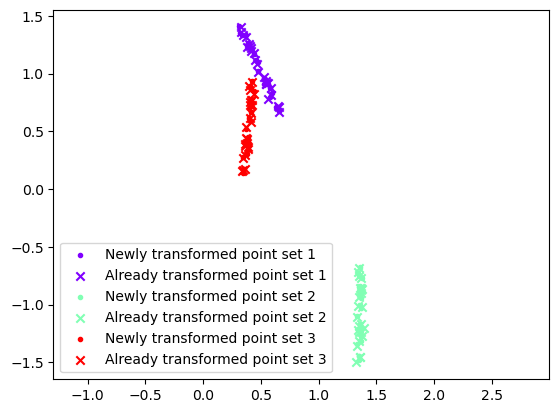

In [165]:
print('Optimal solution: ', res.x)

rot, trans = transformation(res.x, derivative=False)
points_ = points.copy()
points_[:, 0, :, :, :] = rot @ points_[:, 0, :, :, :] + trans

colors = plt.cm.rainbow(np.linspace(0, 1, n_lines))
for i in range(n_lines):
    for j in range(2):
        plt.scatter(points_[i, j, :, 0, 0], points_[i, j, :, 1, 0], 
                    color=colors[i, :], marker='.' if j == 0 else 'x',
                    label=("Newly" if j == 0 else "Already") + f" transformed point set {i+1}")
    
plt.axis('equal')
plt.legend()
plt.show()

Instead of taking the eigenvalues as residuals, we can also compute the point to line distance as it would be done classically in these kind of problems. However, as opposed to those, with our method we do not need to estimate the line's properties by any additional parameters. Remembering from what we explained before, we actually get the definition of each line through the eigenvector corresponding to the smallest eigenvalue. So as in the beginning, the optimization objective is again

$$
\begin{align*}
L(R_1, p_1, ..., R_{N_{Pose}}, p_{N_{Pose}}) = \frac{1}{2}\sum_{i=1}^{N_{Pose}}\sum_{j=1}^{N_{Plane}}\sum_{k=1}^{N_{i, j}}(n_j(R_1, p_1, ..., R_{N_{Pose}}, p_{N_{Pose}}) \cdot (R_i x_k + p_i) - d_j(R_1, p_1, ..., R_{N_{Pose}}, p_{N_{Pose}}))^2
\end{align*}
$$

where however $d_j$ and $n_j$ are now functions of the to the plane corresponding points and the respective spatial transformations $R_i, p_i$. As residuals we take the distance of each point to the line computed through the eigen decomposition. So basically we are getting the lines properties as a byproduct of the optimization process. With this approach, as opposed to the beginning, we do not need any extra parameters. Solely by looking at the covariance matrix of our data points, we computed the points linearity. Trying it out, we see a great improvement in speed.



In [170]:
def f(v):
    eigenvalues, eigenvectors = eigen(v, derivative=False)
    
    rot, trans = transformation(v, derivative=False)
    rot = np.stack([rot, np.eye(2)]).reshape(1, 2, 1, 2, 2)
    trans = np.stack([trans, np.zeros((2, 1))]).reshape(1, 2, 1, 2, 1)
        
    points_ = (rot @ points + trans).reshape(n_lines, -1, 2, 1)
        
    mean = np.mean(points_, axis=-3, keepdims=True)
    distances = np.swapaxes(eigenvectors.reshape(-1, 1, 2, 1), -1, -2) @ (points_ - mean)

    return distances.reshape(-1)
    
def jac_f(v):
    eigenvalues, eigenvectors, d_eigenvalues, d_eigenvectors = eigen(v, derivative=True)
    
    rot, trans, d_rot, d_trans = transformation(v, derivative=True)
    rot = np.stack([rot, np.eye(2)]).reshape(1, 2, 1, 2, 2)
    trans = np.stack([trans, np.zeros((2, 1))]).reshape(1, 2, 1, 2, 1)
    d_rot = np.concatenate([d_rot.reshape(3, 1, 1, 1, 2, 2), np.zeros((3, 1, 1, 1, 2, 2))], axis=2)
    d_trans = np.concatenate([d_trans.reshape(3, 1, 1, 1, 2, 1), np.zeros((3, 1, 1, 1, 2, 1))], axis=2)

    points_ = (rot @ points + trans).reshape(n_lines, -1, 2, 1)
    d_points_ = (d_rot @ points + d_trans).reshape(3, n_lines, -1, 2, 1)
        
    mean = np.mean(points_, axis=-3, keepdims=True)
    d_mean = np.mean(d_points_, axis=-3, keepdims=True)
    
    distances = np.swapaxes(d_eigenvectors.reshape(3, -1, 1, 2, 1), -1, -2) @ (points_ - mean) + \
                np.swapaxes(eigenvectors.reshape(-1, 1, 2, 1), -1, -2) @ (d_points_ - d_mean)
    
    return distances.reshape(3, -1).T

# This approach is more robust than the previous one, so we can start further away from the optimal solution
v_offset = np.array([2, 2, 1])
v0 = v_target - v_offset
res = least_squares(f, v0, jac_f, verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7004e+00                                    4.79e-01    
       1              2         4.8862e-01      1.21e+00       2.06e+00       4.34e-01    
       2              4         2.2777e-01      2.61e-01       1.03e+00       3.56e-02    
       3              5         1.9680e-01      3.10e-02       2.06e+00       1.70e-01    
       4              6         1.6999e-01      2.68e-02       1.82e+00       3.15e+00    
       5              7         2.3290e-02      1.47e-01       1.88e-01       2.03e-01    
       6              8         1.2331e-02      1.10e-02       1.20e-01       5.70e-02    
       7              9         1.2278e-02      5.30e-05       2.37e-03       1.24e-05    
       8             10         1.2278e-02      1.88e-12       6.77e-07       2.28e-10    
`gtol` termination condition is satisfied.
Function evaluations 10, initial cost 1.7004e+0

We can confirm that this solution is again correct.

Optimal solution:  [0.49998324 1.00429842 1.99897692]


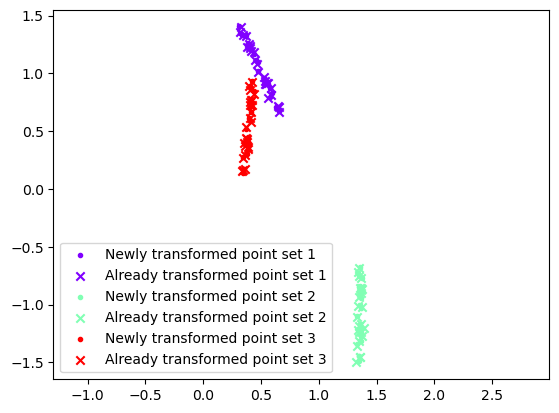

In [171]:
print('Optimal solution: ', res.x)

rot, trans = transformation(res.x, derivative=False)
points_ = points.copy()
points_[:, 0, :, :, :] = rot @ points_[:, 0, :, :, :] + trans

colors = plt.cm.rainbow(np.linspace(0, 1, n_lines))
for i in range(n_lines):
    for j in range(2):
        plt.scatter(points_[i, j, :, 0, 0], points_[i, j, :, 1, 0], 
                    color=colors[i, :], marker='.' if j == 0 else 'x',
                    label=("Newly" if j == 0 else "Already") + f" transformed point set {i+1}")
    
plt.axis('equal')
plt.legend()
plt.show()